In [120]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [121]:
# Load data
train_data = pd.read_csv("../../data/raw/train.csv")
test_data = pd.read_csv("../../data/raw/test.csv")

In [122]:
train_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [123]:
# Function to convert datetime column
def convert_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Extract date and time components
    df['year'] = df['datetime'].dt.year
    df['year'] = df['year'] - np.min(df['year'] - 1)
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    
    # Drop original datetime column
    df = df.drop(columns=['datetime'])

    return df


# Apply datetime conversion to both train and test datasets
train_data = convert_datetime(train_data)
test_data = convert_datetime(test_data)

In [124]:
# Combine train and test datasets
combined_data = pd.concat([train_data, test_data])

# Save length of train dataset
n_train = len(train_data)

# Save original columns
original_columns = combined_data.columns

# Reset index
combined_data = combined_data.reset_index(drop=True)

ADF Statistic: -19.311621
p-value: 0.000000
Distribution is stationary
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


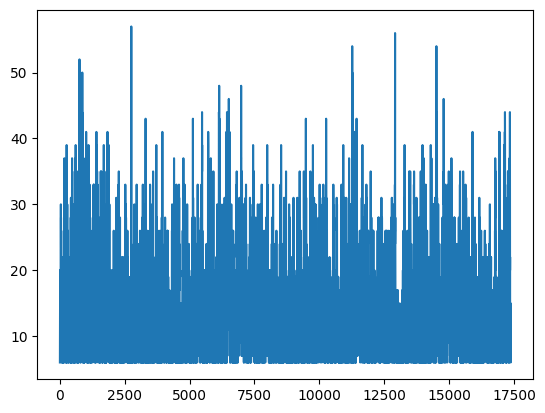

In [125]:
# Check for stationarity of wind speed
mask = combined_data['windspeed'] != 0
combined_data[mask]['windspeed'].plot()

# Check for stationarity of wind speed with hypothesis test
from statsmodels.tsa.stattools import adfuller

result = adfuller(combined_data[mask]['windspeed'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Print if the distribution is stationary or not
if result[1] < 0.05:
    print('Distribution is stationary')
else:
    print('Distribution is non-stationary')

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


In [126]:
def remove_outliers(df, column):
    # Calculate z-score
    z = np.abs((df[column] - df[column].mean()) / df[column].std())
    
    # Set outliers to zero
    df.loc[z > 3, column] = 0
    
    return df

# Remove outliers from windspeed
processed_data = remove_outliers(combined_data, 'windspeed')

In [127]:
def interpolate_wind_gaps(data):
    """
    Handles missing values in windspeed using interpolation.

    Parameters:
    data (DataFrame): The combined dataset containing the windspeed column.

    Returns:
    DataFrame: The combined dataset with the interpolated windspeed values.
    """

    # Convert windspeed column to numeric, replacing non-numeric values with NaN
    data['windspeed'] = pd.to_numeric(data['windspeed'], errors='coerce')

    # Set to zero negative values in windspeed
    data['windspeed'] = data['windspeed'].apply(lambda x: 0 if x < 0 else x)

    # Replace 0 values in windspeed with NaN
    data['windspeed_interp'] = data['windspeed'].replace(0, np.nan)

    # Count number of missing values in windspeed_interp
    n_missing = data['windspeed_interp'].isnull().sum()
    print(f"Number of missing values in windspeed_interp: {n_missing}")

    # Interpolate missing values in windspeed column
    data['windspeed_interp'] = data['windspeed_interp'].interpolate(method='spline', order=3)

    # Count number of missing values in windspeed_interp
    n_missing = data['windspeed_interp'].isnull().sum()
    print(f"Number of missing values in windspeed_interp after interpolation: {n_missing}")

    return data

# Apply fill_wind_gaps function to the combined dataset
processed_data = interpolate_wind_gaps(processed_data)

# Use bfill and ffill to fill remaining missing values
processed_data = processed_data.bfill()
processed_data = processed_data.ffill()
print(f'Number of missing values in windspeed_interp after everything: {processed_data.isnull().sum().sum()}')

Number of missing values in windspeed_interp: 2287
Number of missing values in windspeed_interp after interpolation: 5
Number of missing values in windspeed_interp after everything: 0


In [128]:
def smooth_features(processed_data, features_to_smooth):
    """
    Smooths features using a rolling average.

    Parameters:
    processed_data (DataFrame): The combined dataset containing the features to smooth.
    features_to_smooth (list): A list of features to smooth.

    Returns:
    DataFrame: The combined dataset with the smoothed features.
    """

    # Smooth features using a rolling average
    for feature in features_to_smooth:
        processed_data[feature] = processed_data[feature].rolling(window=5, min_periods=1).mean()

    return processed_data

# Apply smooth_features function to the combined dataset
features_to_smooth = ['temp', 'atemp', 'windspeed_interp']
processed_data = smooth_features(processed_data, features_to_smooth)

In [129]:
processed_data

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,windspeed_interp
0,1,0,0,1,9.840000,14.395000,81,0.0000,3.0,13.0,16.0,1,1,1,0,6.00320
1,1,0,0,1,9.430000,14.015000,80,0.0000,8.0,32.0,40.0,1,1,1,1,6.00320
2,1,0,0,1,9.293333,13.888333,80,0.0000,5.0,27.0,32.0,1,1,1,2,6.00320
3,1,0,0,1,9.430000,14.015000,75,0.0000,3.0,10.0,13.0,1,1,1,3,6.00320
4,1,0,0,1,9.512000,14.091000,75,0.0000,0.0,1.0,1.0,1,1,1,4,6.00320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,1,2,10.824000,13.637000,60,11.0014,4.0,84.0,88.0,2,12,31,19,9.59976
17375,1,0,1,2,10.660000,13.334000,60,11.0014,4.0,84.0,88.0,2,12,31,20,10.00042
17376,1,0,1,1,10.660000,13.334000,60,11.0014,4.0,84.0,88.0,2,12,31,21,9.60110
17377,1,0,1,1,10.660000,13.182000,56,8.9981,4.0,84.0,88.0,2,12,31,22,10.20008


In [130]:
def create_lagged_features(processed_data):

    lagged_features_wind = pd.DataFrame()
    lagged_features_not_wind = pd.DataFrame()
    wind_lags = [8, 7, 6, 5, 4, 3, 2, 1, 24, 48, 72]
    humidity_lags = [3, 2, 1]
    temp_lags = [3, 2, 1]

    for lag in wind_lags:
        lagged_features_wind[f'wind, t-{lag}'] = processed_data['windspeed_interp'].shift(lag)
        lagged_features_wind[f'wind, t+{lag}'] = processed_data['windspeed_interp'].shift(-lag)

        # If the first value is missing, replace with the second one on each row
        lagged_features_wind[f'wind, t-{lag}'] = lagged_features_wind[f'wind, t-{lag}'].combine_first(lagged_features_wind[f'wind, t+{lag}'])

        # If the second value is missing, replace with the first one on each row
        lagged_features_wind[f'wind, t+{lag}'] = lagged_features_wind[f'wind, t+{lag}'].combine_first(lagged_features_wind[f'wind, t-{lag}'])   

    for lag in humidity_lags:
        lagged_features_not_wind[f'hum, t-{lag}'] = processed_data['humidity'].shift(lag)
        lagged_features_not_wind[f'hum, t+{lag}'] = processed_data['humidity'].shift(-lag)

        # If the first value is missing, replace with the second one on each row
        lagged_features_not_wind[f'hum, t-{lag}'] = lagged_features_not_wind[f'hum, t-{lag}'].combine_first(lagged_features_not_wind[f'hum, t+{lag}'])

        # If the second value is missing, replace with the first one on each row
        lagged_features_not_wind[f'hum, t+{lag}'] = lagged_features_not_wind[f'hum, t+{lag}'].combine_first(lagged_features_not_wind[f'hum, t-{lag}'])

    for lag in temp_lags:
        
        lagged_features_not_wind[f'temp, t-{lag}'] = processed_data['temp'].shift(lag)
        lagged_features_not_wind[f'temp, t+{lag}'] = processed_data['temp'].shift(-lag)

        # If the first value is missing, replace with the second one on each row
        lagged_features_not_wind[f'temp, t-{lag}'] = lagged_features_not_wind[f'temp, t-{lag}'].combine_first(lagged_features_not_wind[f'temp, t+{lag}'])

        # If the second value is missing, replace with the first one on each row
        lagged_features_not_wind[f'temp, t+{lag}'] = lagged_features_not_wind[f'temp, t+{lag}'].combine_first(lagged_features_not_wind[f'temp, t-{lag}'])

    return lagged_features_wind, lagged_features_not_wind

# Apply create_lagged_features function to the combined dataset
lagged_features_wind, lagged_features_not_wind = create_lagged_features(processed_data)


In [131]:
def combine_features(processed_data, lagged_features_wind, lagged_features_not_wind, use_wind=True):
    """
    Combines the original features with the lagged features.

    Parameters:
    processed_data (DataFrame): The combined dataset containing the original features.
    lagged_features_wind (DataFrame): The lagged wind features.
    lagged_features_not_wind (DataFrame): The lagged features that are not wind.
    use_wind (bool): Whether to include the wind lagged features.

    Returns:
    DataFrame: The combined dataset with the lagged features.
    """

    # Combine original features with lagged features
    if use_wind:
        processed_data = pd.concat([processed_data, lagged_features_wind], axis=1)
    
    processed_data = pd.concat([processed_data, lagged_features_not_wind], axis=1)

    return processed_data

# Apply combine_features function to the combined dataset
final_data = combine_features(processed_data, lagged_features_wind, lagged_features_not_wind, use_wind=True)
print(len(final_data))

17379


In [132]:
# Separate data with missing windspeed values and with valid windspeed values
missing_wind_mask = final_data['windspeed'] == 0
data_with_missing_wind = final_data[missing_wind_mask]
data_without_missing_wind = final_data[~missing_wind_mask]
print(len(data_with_missing_wind), len(data_without_missing_wind))

# Define features not to use in traning and target variable
features_to_drop = ['windspeed', 'holiday', 'workingday', 'casual', 'registered', 'count', 'windspeed_interp', 'year', 'month', 'day', 'season']
target_variable = 'windspeed'

2287 15092


In [133]:
data_with_missing_wind

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,"hum, t-2","hum, t+2","hum, t-1","hum, t+1","temp, t-3","temp, t+3","temp, t-2","temp, t+2","temp, t-1","temp, t+1"
0,1,0,0,1,9.840000,14.395000,81,0.0,3.0,13.0,...,80.0,80.0,80.0,80.0,9.430,9.430,9.293333,9.293333,9.430000,9.430000
1,1,0,0,1,9.430000,14.015000,80,0.0,8.0,32.0,...,75.0,75.0,81.0,80.0,9.512,9.512,9.430000,9.430000,9.840000,9.293333
2,1,0,0,1,9.293333,13.888333,80,0.0,5.0,27.0,...,81.0,75.0,80.0,75.0,9.512,9.512,9.840000,9.512000,9.430000,9.430000
3,1,0,0,1,9.430000,14.015000,75,0.0,3.0,10.0,...,80.0,75.0,80.0,75.0,9.840,9.512,9.430000,9.512000,9.293333,9.512000
4,1,0,0,1,9.512000,14.091000,75,0.0,0.0,1.0,...,80.0,80.0,75.0,75.0,9.430,9.348,9.293333,9.512000,9.430000,9.512000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17330,1,0,0,2,11.480000,12.120000,60,0.0,4.0,84.0,...,56.0,56.0,60.0,60.0,11.972,10.660,11.808000,10.824000,11.808000,11.152000
17341,1,0,0,1,10.004000,10.303000,41,0.0,4.0,84.0,...,52.0,36.0,52.0,41.0,10.332,10.988,10.168000,10.496000,10.004000,10.168000
17343,1,0,0,1,10.496000,10.758000,36,0.0,4.0,84.0,...,41.0,36.0,41.0,36.0,10.004,11.644,10.004000,11.480000,10.168000,10.988000
17344,1,0,0,1,10.988000,11.364000,36,0.0,4.0,84.0,...,41.0,38.0,36.0,36.0,10.004,11.808,10.168000,11.644000,10.496000,11.480000


In [134]:
# Split data into train and test sets
wind_train, wind_test = train_test_split(data_without_missing_wind, test_size=0.2, random_state=10)

# Define features to use in training
wind_features = [col for col in wind_train.columns if col not in features_to_drop]

X_train, y_train = wind_train[wind_features], wind_train[target_variable]
X_test, y_test = wind_test[wind_features], wind_test[target_variable]

In [135]:
# Pipeline for neural network model
neural_net_pipe = make_pipeline(StandardScaler(), MLPRegressor(verbose=True, max_iter=1000))
neural_net_pipe.fit(X_train, y_train)

# Pipeline for random forest model
random_forest_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(verbose=True))
random_forest_pipe.fit(X_train, y_train)

Iteration 1, loss = 87.37198011
Iteration 2, loss = 30.62933833
Iteration 3, loss = 15.49245495
Iteration 4, loss = 12.15647901
Iteration 5, loss = 10.63462182
Iteration 6, loss = 9.60484874
Iteration 7, loss = 8.81806437
Iteration 8, loss = 8.13799297
Iteration 9, loss = 7.54508692
Iteration 10, loss = 7.00233150
Iteration 11, loss = 6.50785154
Iteration 12, loss = 6.05955671
Iteration 13, loss = 5.64308083
Iteration 14, loss = 5.27062053
Iteration 15, loss = 4.92600770
Iteration 16, loss = 4.61862882
Iteration 17, loss = 4.34134224
Iteration 18, loss = 4.09310182
Iteration 19, loss = 3.86146918
Iteration 20, loss = 3.66725432
Iteration 21, loss = 3.48587829
Iteration 22, loss = 3.32920984
Iteration 23, loss = 3.19564859
Iteration 24, loss = 3.06415106
Iteration 25, loss = 2.94298119
Iteration 26, loss = 2.85351663
Iteration 27, loss = 2.75255014
Iteration 28, loss = 2.67317404
Iteration 29, loss = 2.58561810
Iteration 30, loss = 2.50871371
Iteration 31, loss = 2.45094536
Iteration 32

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.6s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor(verbose=True))])

In [136]:
# Compare predictions from both models
neural_net_pred = neural_net_pipe.predict(X_test)
random_forest_pred = random_forest_pipe.predict(X_test)

# Calculate mean squared error for both models
neural_net_mse = np.mean((neural_net_pred - y_test) ** 2)
random_forest_mse = np.mean((random_forest_pred - y_test) ** 2)

# Print the mean squared error for both models
print(f"Neural Network MSE: {neural_net_mse}")
print(f"Random Forest MSE: {random_forest_mse}")
print('')
print(f"Neural Network R2: {neural_net_pipe.score(X_test, y_test)}")
print(f"Random Forest R2: {random_forest_pipe.score(X_test, y_test)}")

print('')

# Create and print most important variables dataframe from random forest model
importances = random_forest_pipe.named_steps['randomforestregressor'].feature_importances_
importances_df = pd.DataFrame(importances, index=wind_features, columns=['importance'])
importances_df = importances_df.sort_values(by='importance', ascending=False)

#print dataframe with rounded importance values
print(importances_df.round(5))

Neural Network MSE: 3.4588327425412757
Random Forest MSE: 6.399888785581911

Neural Network R2: 0.9212277741100058
Random Forest R2: 0.8542475098930914

            importance
wind, t+2      0.80854
wind, t+5      0.02339
wind, t+4      0.01887
wind, t-1      0.01463
wind, t+1      0.01442
wind, t+3      0.01218
wind, t+24     0.00610
wind, t+6      0.00606
wind, t-2      0.00545
wind, t+8      0.00545
wind, t-48     0.00530
wind, t-24     0.00522
wind, t-72     0.00520
wind, t+72     0.00506
wind, t+48     0.00496
wind, t+7      0.00457
wind, t-8      0.00394
hour           0.00371
wind, t-3      0.00369
wind, t-4      0.00358
wind, t-5      0.00310
hum, t+3       0.00300
hum, t-3       0.00296
wind, t-7      0.00274
wind, t-6      0.00269
humidity       0.00257
hum, t-2       0.00248
hum, t+1       0.00238
temp, t-3      0.00232
hum, t-1       0.00230
hum, t+2       0.00228
temp, t+3      0.00211
atemp          0.00162
temp, t-2      0.00145
temp, t+2      0.00138
temp, t+1      0.00

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [137]:
# Combine predictions from both models using a weighted average
neural_net_weight = 0.5
random_forest_weight = 1 - neural_net_weight

def calculate_mse(weight):

    # Calculate the combined prediction using the given weights
    combined_pred = (weight * neural_net_pred) + ((1-weight) * random_forest_pred)

    # Calculate the mean squared error of the combined model
    mse = np.mean((combined_pred - y_test) ** 2)

    return mse

# Run an optimiser on the weights to find the best combination using scipy.minimise
from scipy.optimize import minimize

# Define the initial weights
initial_weight = neural_net_weight

# Run the optimiser
result = minimize(calculate_mse, initial_weight)

# Print the optimised weights and mean squared error
print("Minimised MSE: ",result.fun)
print("Minimised MAE: ", np.mean(np.abs(result.x * neural_net_pred + (1-result.x) * random_forest_pred - y_test)))
print("Optimised weights: ", result.x[0], 1-result.x[0])


Minimised MSE:  3.417289050762029
Minimised MAE:  1.3968843640216364
Optimised weights:  0.8944385048718062 0.1055614951281938


In [138]:
# Predict windspeed for data with missing values
missing_wind_features = [col for col in data_with_missing_wind.columns if col not in features_to_drop]
missing_wind_pred = (result.x * neural_net_pipe.predict(data_with_missing_wind[missing_wind_features])) + ((1-result.x) * random_forest_pipe.predict(data_with_missing_wind[missing_wind_features]))

# Replace missing windspeed values with predictions
combined_data.loc[missing_wind_mask, 'windspeed'] = missing_wind_pred

# Divide back into train and test datasets, using only the original columns
train_data_with_wind = combined_data.iloc[:n_train][original_columns]
test_data_with_wind = combined_data.iloc[n_train:][original_columns]

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [139]:
train_data_with_wind

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,6.916657,3.0,13.0,16.0,1,1,1,0
1,1,0,0,1,9.02,13.635,80,6.545093,8.0,32.0,40.0,1,1,1,1
2,1,0,0,1,9.02,13.635,80,6.438757,5.0,27.0,32.0,1,1,1,2
3,1,0,0,1,9.84,14.395,75,6.643728,3.0,10.0,13.0,1,1,1,3
4,1,0,0,1,9.84,14.395,75,5.687297,0.0,1.0,1.0,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.002700,7.0,329.0,336.0,2,12,19,19
10882,4,0,1,1,14.76,17.425,57,15.001300,10.0,231.0,241.0,2,12,19,20
10883,4,0,1,1,13.94,15.910,61,15.001300,4.0,164.0,168.0,2,12,19,21
10884,4,0,1,1,13.94,17.425,61,6.003200,12.0,117.0,129.0,2,12,19,22


In [141]:
# Save the processed data
train_data_with_wind.to_csv("../../data/processed/train_with_wind.csv", index=False)
test_data_with_wind.to_csv("../../data/processed/test_with_wind.csv", index=False)